## Importando bibliotecas

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR, LinearSVR
# from sklearn.model_selection import GridSearchCV
import re


pd.set_option('display.max_columns', None)

## Importando dados

Transformações realizadas:

* `ano_modelo` e `num_fotos`: alterados para `int`;
* `dono_aceita_troca`, `veiculo_único_dono`, `revisoes_concessionaria`, `ipva_pago`, `veiculo_licenciado`,
`garantia_de_fábrica`, `revisoes_dentro_agenda`, `blindado`: alterados para booleanos (1 ou 0);
* `veiculo_alienado` e `elegivel_revisao`: removidos pois todas as observações são iguais;
* `tipo_vendedor`: alterado para `vendedor_PJ` e transformado em booleano.

In [198]:
# Ler dados de treino
df = pd.read_csv('./dataset/cars_train.csv', sep='\t', encoding='utf_16')

# Transformar para inteiro
df['ano_modelo'] = df.ano_modelo.astype(int)
df['num_fotos'] = df.num_fotos.fillna(0).astype(int)

# Transformar em booleanos
df['dono_aceita_troca'] = df.dono_aceita_troca.notnull().astype(int)
df['veiculo_único_dono'] = df.veiculo_único_dono.notnull().astype(int)
df['revisoes_concessionaria'] = df.revisoes_concessionaria.notnull().astype(int)
df['ipva_pago'] = df.ipva_pago.notnull().astype(int)
df['veiculo_licenciado'] = df.veiculo_licenciado.notnull().astype(int)
df['garantia_de_fábrica'] = df.garantia_de_fábrica.notnull().astype(int)
df['revisoes_dentro_agenda'] = df.revisoes_dentro_agenda.notnull().astype(int)
df['entrega_delivery'] = df.entrega_delivery.astype(int)
df['troca'] = df.troca.astype(int)
df['blindado'] = df.blindado.map({'N': 0, 'S': 1})

# Colunas descartadas
df.drop(columns=['veiculo_alienado'], inplace=True)
df.drop(columns=['elegivel_revisao'], inplace=True)

# Remapeando tipo_vendedor e alterando o nome da variável
df['tipo_vendedor'] = df.tipo_vendedor.map({'PJ': 1, 'PF': 0})
df.rename(columns={'tipo_vendedor':'vendedor_PJ'}, inplace=True)

## Modelos

Para os modelos de Machine Learning, iremos treinar um modelo base e iremos usar seus resultados como benchmark e compará-los com os demais.

Para modelos lineares estaremos utilizando o `StandardScaler` para escalonar os dados, uma vez que esse tipo de algoritmo de Machine Learning é sensível à dados que não estão em escala. 

Para avaliar os testes realizados, faremos uso de um K-Fold com 5 splits, e avaliaremos os scores obtidos pelo modelo.

Quanto as métricas utilizadas, optamos pelo R² e pelo RMSE (raiz do erro quadrático médio). O R² é uma medida de 0 a 1 que expressa a quantidade da variância dos dados, já o RMSE é a raiz da soma dos quadrados dos erros, e tem a vantagem de estar na mesma unidade de medida que o próprio target (neste caso R$).

### Modelo 1 - LinearRegression

O primeiro modelo que testaremos será o de regressão linear. Isso porque esse algoritmo é um dos mais simples e tem uma boa interpretabilidade dos resultados.

Porém, devemos nos atentar com as variáveis categóricas. A princípio, vamos transformar as features `tipo`, `cambio`, `cor` e `anunciante` em dummies, removendo o primeiro valor de cada (drop_first), a fim de evitar problemas de colinearidade.

In [156]:
df1 = pd.get_dummies(df, columns=['tipo', 'cambio', 'cor', 'anunciante'], drop_first=True)

X = df1.select_dtypes(np.number).drop(columns=['preco'])
y = df1.preco

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=31)

kfold = KFold(n_splits=5, random_state=31, shuffle=True)

modelo1 = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

cv_results = cross_validate(modelo1, X_train, y_train, cv=kfold, scoring=['r2', 'neg_root_mean_squared_error'])

r2_scores_cv = cv_results['test_r2']
rmse_scores_cv = cv_results['test_neg_root_mean_squared_error']

print('Cross-validation')
print('Scores do CV (R2):', r2_scores_cv)
print('Média (R2):', r2_scores_cv.mean().round(3))
print('Scores do CV (RMSE):', rmse_scores_cv)
print('Média (RMSE):', rmse_scores_cv.mean().round(2))

print('-'*64)

print('Testes no conjunto de validação')
modelo1.fit(X_train, y_train)
y_pred1 = modelo1.predict(X_val)
r2_scores_val = r2_score(y_val, y_pred1)
rmse_scores_val = -mean_squared_error(y_val, y_pred1, squared=False)
print(f'Score R2: {r2_scores_val:.3f}')
print(f'Score RMSE: {rmse_scores_val:.2f}')

Cross-validation
Scores do CV (R2): [0.44780067 0.42074739 0.44553292 0.4054545  0.41848432]
Média (R2): 0.428
Scores do CV (RMSE): [-59121.66893193 -62573.78819719 -59098.22219976 -64602.2303613
 -63065.1921713 ]
Média (RMSE): -61692.22
----------------------------------------------------------------
Testes no conjunto de validação
Score R2: 0.426
Score RMSE: -62081.36


Vamos armazenar os resultados dos modelos em um data frame para comparar suas performances.

In [157]:
# Pintar de laranja os maiores valores
def highlight_max(element):
    is_max = (element == element.max())
    return ['background: darkorange' if cell == True else '' for cell in is_max]

In [158]:
modelos = pd.DataFrame([{'modelo': 'modelo1',
                        'algoritmo':'LinearRegression', 
                        'r2_score': r2_scores_val.round(3), 
                        'rmse_score': rmse_scores_val.round(2)}]).set_index('modelo')
modelos.style.apply(highlight_max)

,algoritmo,r2_score,rmse_score
modelo,,,
modelo1,LinearRegression,0.426000,-62081.360000


A seguir um gráfico que compara os valores preditos e valores reais dos preços dos veículos.

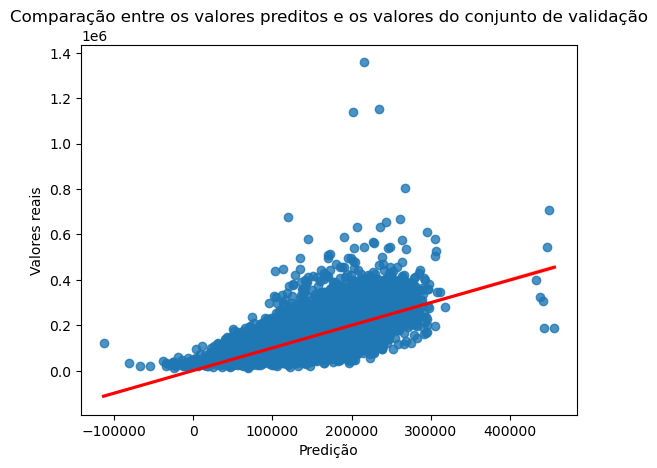

In [159]:
sns.regplot(x=y_pred1, y=y_val, line_kws={'color': 'red'})
plt.xlabel('Predição')
plt.ylabel('Valores reais')
plt.title('Comparação entre os valores preditos e os valores do conjunto de validação')
plt.show()

As categorias dropadas pelo `drop_first` foram as seguintes:

In [160]:
set(pd.get_dummies(df, columns=['tipo', 'cambio', 'cor', 'anunciante'])) - set(pd.get_dummies(df, columns=['tipo', 'cambio', 'cor', 'anunciante'], drop_first=True).columns)

{'anunciante_Acessórios e serviços para autos',
 'cambio_Automatizada',
 'cor_Branco',
 'tipo_Cupê'}

A seguir um gráfico que mostra a importância de cada uma das variáveis.

In [161]:
coef = modelo1.named_steps['regressor'].coef_

display(pd.Series(data=coef, index=X.columns))

num_fotos                       5.959937e+03
ano_de_fabricacao               1.229410e+04
ano_modelo                     -3.988279e+03
hodometro                      -2.217463e+04
num_portas                     -4.082189e+03
blindado                        3.848544e+03
vendedor_PJ                    -6.962999e+03
entrega_delivery               -1.905984e+03
troca                           1.447227e+03
dono_aceita_troca               1.334447e+04
veiculo_único_dono             -4.868548e+03
revisoes_concessionaria         8.940461e+03
ipva_pago                      -2.068955e+03
veiculo_licenciado             -1.483199e+02
garantia_de_fábrica             4.511784e+02
revisoes_dentro_agenda          1.311147e+02
tipo_Hatchback                 -9.661324e+04
tipo_Minivan                   -4.112804e+03
tipo_Perua/SW                  -5.695628e+03
tipo_Picape                    -7.684663e+04
tipo_Sedã                      -1.271116e+05
tipo_Utilitário esportivo      -5.408659e+04
cambio_Aut

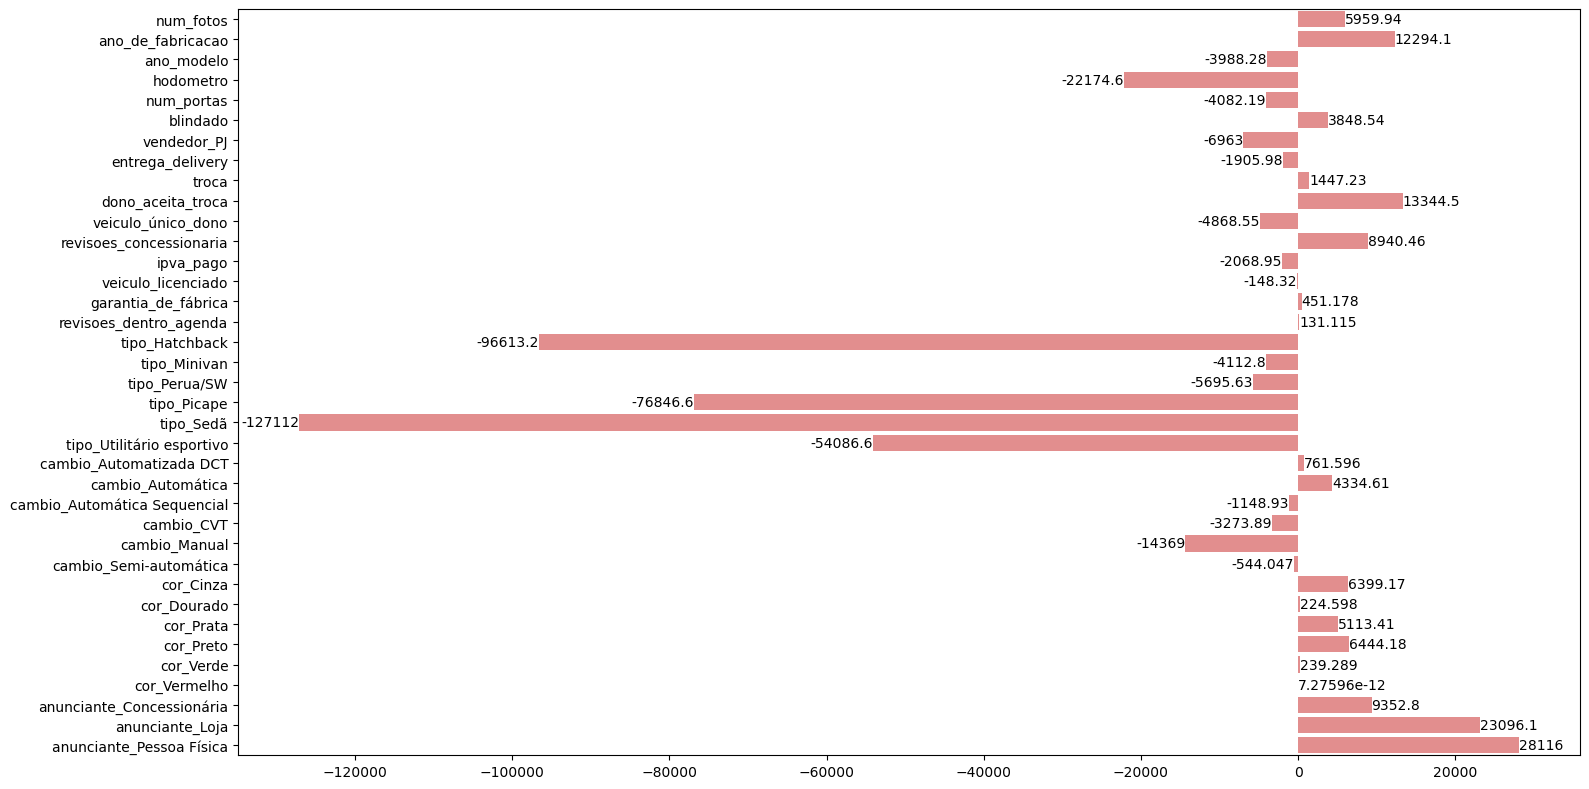

In [162]:
plt.figure(figsize=(16, 8))
ax = sns.barplot(y=X.columns, x=coef, color='lightcoral')
ax.bar_label(ax.containers[0])
ax.figure.tight_layout()
plt.show()

Pelos resultados obtidos do modelo, os coeficientes que mais estão impactando na predição do preço estão relacionadas ao tipo de veículo.

### Modelo 2 - RandomForest

O segundo modelo que testaremos é o RandomForest. Esse tipo de modelo tem a grande vantagem de trabalhar bem com variáveis categóricas.
A seguir, vamos transformar as variáveis que antes eram dummies em categorias propriamente ditas. Além disso, não será necessário utilizar o `StandardScaler` uma vez que este tipo de algoritmo não sofre com dados fora de escala.

In [163]:
df2 = df.copy()
df2['tipo'] = df2['tipo'].astype('category').cat.codes
df2['cambio'] = df2['cambio'].astype('category').cat.codes
df2['cor'] = df2['cor'].astype('category').cat.codes
df2['anunciante'] = df2['anunciante'].astype('category').cat.codes

df2['marca'] = df2['marca'].astype('category').cat.codes
df2['modelo'] = df2['modelo'].astype('category').cat.codes
df2['versao'] = df2['versao'].astype('category').cat.codes
df2['estado_vendedor'] = df2['estado_vendedor'].astype('category').cat.codes
df2.drop(columns='cidade_vendedor', inplace=True)

X = df2.drop(columns=['preco', 'id'])
y = df2.preco

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=31)

kfold = KFold(n_splits=5, random_state=31, shuffle=True)

modelo2 = RandomForestRegressor(n_estimators=100, random_state=31, n_jobs=-1)

cv_results = cross_validate(modelo2, X_train, y_train, cv=kfold, scoring=['r2', 'neg_root_mean_squared_error'])

r2_scores_cv = cv_results['test_r2']
rmse_scores_cv = cv_results['test_neg_root_mean_squared_error']

print('Cross-validation')
print('Scores do CV (R2):', r2_scores_cv)
print('Média (R2):', r2_scores_cv.mean().round(3))
print('Scores do CV (RMSE):', rmse_scores_cv)
print('Média (RMSE):', rmse_scores_cv.mean().round(2))

print('-'*64)

print('Testes no conjunto de validação')
modelo2.fit(X_train, y_train)
y_pred2 = modelo2.predict(X_val)
r2_scores_val = r2_score(y_val, y_pred2)
rmse_scores_val = -mean_squared_error(y_val, y_pred2, squared=False)
print(f'Score R2: {r2_scores_val:.3f}')
print(f'Score RMSE: {rmse_scores_val:.2f}')

Cross-validation
Scores do CV (R2): [0.72182901 0.7315763  0.72294216 0.70163202 0.68430552]
Média (R2): 0.712
Scores do CV (RMSE): [-41961.853247   -42596.00533469 -41775.50944505 -45764.74775197
 -46466.77176601]
Média (RMSE): -43712.98
----------------------------------------------------------------
Testes no conjunto de validação
Score R2: 0.727
Score RMSE: -42773.77


In [164]:
modelos = pd.concat([modelos,
                     pd.DataFrame([{'modelo': 'modelo2',
                                    'algoritmo': 'RandomForestRegressor',
                                    'r2_score': r2_scores_val.round(3),
                                    'rmse_score': rmse_scores_val.round(2)}]).set_index('modelo')
                                    ])
modelos.style.apply(highlight_max)
# modelos

,algoritmo,r2_score,rmse_score
modelo,,,
modelo1,LinearRegression,0.426000,-62081.360000
modelo2,RandomForestRegressor,0.727000,-42773.770000


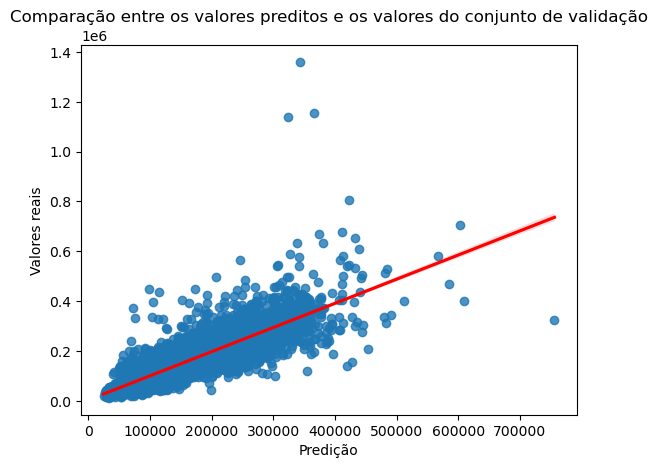

In [165]:
sns.regplot(x=y_pred2, y=y_val, line_kws={'color': 'red'})
plt.xlabel('Predição')
plt.ylabel('Valores reais')
plt.title('Comparação entre os valores preditos e os valores do conjunto de validação')
plt.show()

## Feature engineering

Vamos realizar feature engineering para extrair informações presentes na coluna de versão do carro, uma vez que não conseguimos utilizar essa coluna para o modelo de regressão linear.

In [200]:
# Copiando data frame original
df_ft_eng = df.copy()

### Feature `motor`


Vamos utilizar os 3 primeiros dígitos para determinar as cilindradas do motor (ex: 1.0, 1.4, 2.0, etc.). Os carros elétricos não possuem valor de cilindradas, neste caso serão considerados iguais a 0.0.

In [201]:
# os 3 primeiros digitos referem-se as cilindradas do motor
# para os carros elétricos, que não tem essa identificação, o motor foi considerado como igual a 0
df_ft_eng['motor'] = df_ft_eng.versao.str.slice(0, 3).apply(lambda x: float(x) if re.findall('^\d\.\d$', x) else 0.0)
df_ft_eng['motor']

0        1.6
1        2.0
2        2.4
3        2.0
4        2.0
        ... 
29579    2.8
29580    1.0
29581    2.8
29582    1.6
29583    3.0
Name: motor, Length: 29584, dtype: float64

### Feature `combustivel`

A maioria dos carros estava apresentando o tipo de combustível do veículo. As únicas excessões eram alguns carros da Volkswagen (que eram flex), e carros importados (que eram à gasolina).

In [202]:
combustivel = df_ft_eng.versao.apply(lambda car: 'gasolina' if re.findall('GAS', car) else\
                                    ('flex' if re.findall('FLEX|TETRAFUEL', car) else \
                                    ('diesel' if re.findall('DIESEL', car) else \
                                    ('eletrico' if re.findall('ELETRI|ELÉTRI|ELECTRI|RECHARG', car) else \
                                    ('hibrido' if re.findall('HÍBRID|HYBRID|HIBRID', car) else \
                                    ('flex' if re.findall('1\.', car) else 'gasolina')))))) # carros da volkswagen que são flex
df_ft_eng['combustivel'] = combustivel
df_ft_eng['combustivel']

0            flex
1            flex
2        gasolina
3          diesel
4          diesel
           ...   
29579      diesel
29580        flex
29581      diesel
29582        flex
29583    gasolina
Name: combustivel, Length: 29584, dtype: object

### Features `4x4` e `turbo`

Outras features que foram extraídas foram se o veículo é 4x4 e se é turbo:

In [203]:
df_ft_eng['4x4'] = df_ft_eng.versao.str.contains('4X4')
df_ft_eng['turbo'] = df_ft_eng.versao.str.contains('TURBO')

display(df_ft_eng['4x4'])
display(df_ft_eng['turbo'])

0        False
1        False
2        False
3         True
4         True
         ...  
29579     True
29580    False
29581     True
29582    False
29583    False
Name: 4x4, Length: 29584, dtype: bool

0        False
1        False
2        False
3         True
4         True
         ...  
29579     True
29580    False
29581    False
29582    False
29583    False
Name: turbo, Length: 29584, dtype: bool

### Análise das features

Vamos realizar uma análise rápida de como as features se comparam, principalmente com relação ao nosso target.

In [204]:
display(
    df_ft_eng.groupby('motor').preco.mean(), 
    df_ft_eng.groupby('combustivel').preco.mean(), 
    df_ft_eng.groupby('4x4').preco.mean(), 
    df_ft_eng.groupby('turbo').preco.mean()
)

motor
0.0    246632.879083
0.6    220434.917144
1.0     79865.234668
1.2     49097.244958
1.3    125343.131239
1.4    100025.930860
1.5    108275.142917
1.6    104157.744987
1.7     38398.771642
1.8     91791.807639
1.9     97851.979700
2.0    150055.235390
2.1    156963.098196
2.2    168547.864874
2.3    160659.056177
2.4    113263.301018
2.5    169580.286712
2.7    152259.368243
2.8    231723.688385
2.9    339603.040687
3.0    222598.441463
3.2    198528.821737
3.3    137763.366471
3.5    121376.613455
3.6    164998.677979
3.7     42767.636222
3.8     94533.425051
3.9     71517.534806
4.0    309406.665867
4.1     49924.864046
4.2     99064.225438
4.3     58022.666181
4.4    214123.944767
4.5     57353.165471
4.6     73231.468807
4.7    126822.068318
4.8    108885.328867
4.9     72792.384420
5.0    286501.055520
5.2     62731.123316
5.5    140032.037259
5.7    190230.410261
5.9    125309.699880
6.2    201085.158129
6.7    321207.866029
Name: preco, dtype: float64

combustivel
diesel      196432.297513
eletrico    248486.768056
flex        100971.230204
gasolina    161622.128140
hibrido     244669.483136
Name: preco, dtype: float64

4x4
False    124345.131033
True     189395.069191
Name: preco, dtype: float64

turbo
False    122583.166268
True     166426.753422
Name: preco, dtype: float64

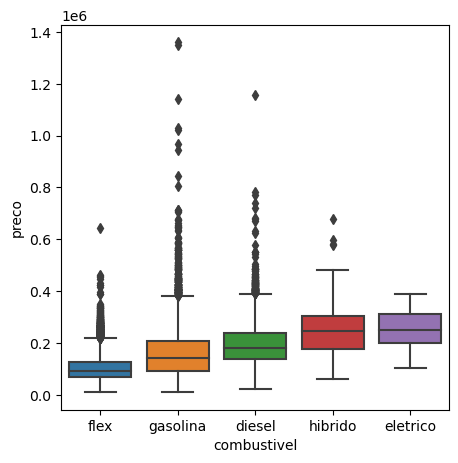

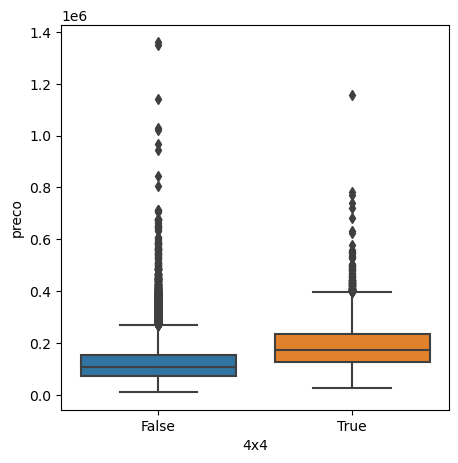

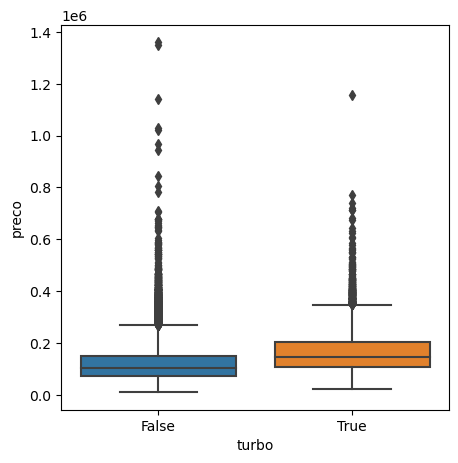

In [205]:
colunas_novas_features = ['combustivel', '4x4', 'turbo']

for feature in colunas_novas_features:
    plt.figure(figsize=(5, 5))
    sns.boxplot(df_ft_eng, x=feature, y='preco')
    plt.show()

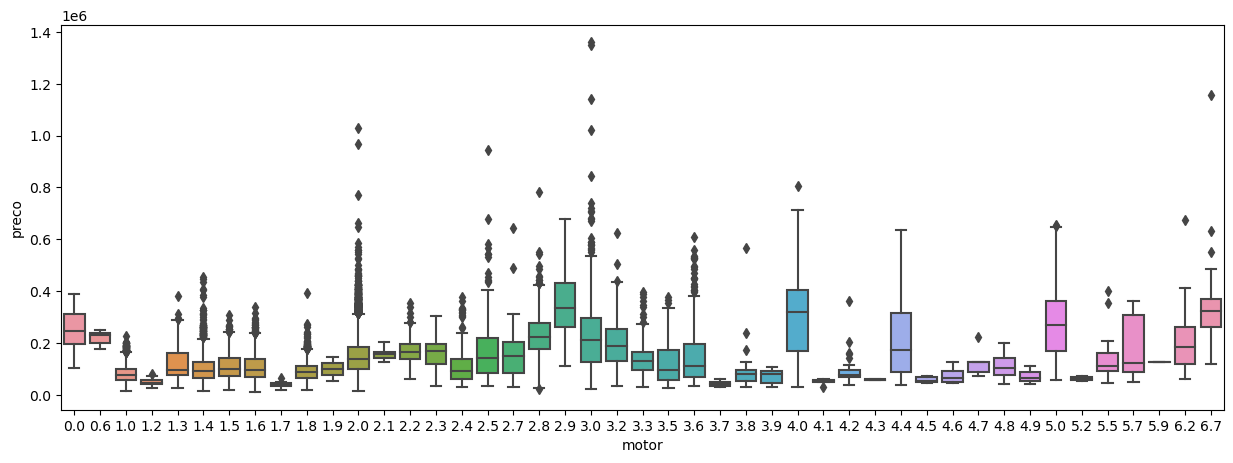

In [206]:
plt.figure(figsize=(15, 5))
sns.boxplot(df_ft_eng, x='motor', y='preco')
plt.show()

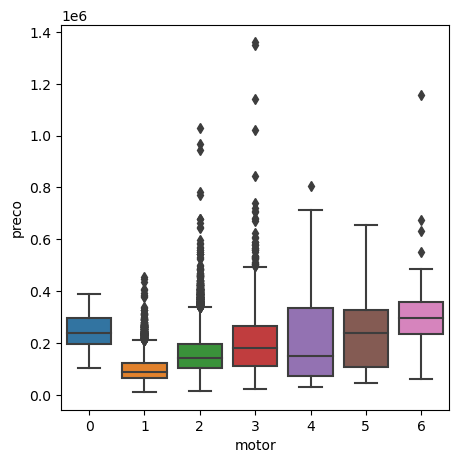

In [173]:
plt.figure(figsize=(5, 5))
sns.boxplot(x=df_ft_eng['motor'].astype(int), y=df_ft_eng['preco'])
plt.show()

## Modelo 3 - LinearRegression com novas features

Agora faremos os testes novamente utilizando o modelo de Regressão Linear, porém incluindo as features previamente extraídas.

In [174]:
# Criando dummies e removendo a primeira para evitar problemas de colinearidade
df3 = pd.get_dummies(df_ft_eng, columns=['tipo', 'cambio', 'cor', 'anunciante', 'combustivel'], drop_first=True)

X = df3.select_dtypes(np.number).drop(columns=['preco'])
y = df3.preco

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=31)

kfold = KFold(n_splits=5, random_state=31, shuffle=True)

modelo3 = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

cv_results = cross_validate(modelo3, X_train, y_train, cv=kfold, scoring=['r2', 'neg_root_mean_squared_error'])

r2_scores_cv = cv_results['test_r2']
rmse_scores_cv = cv_results['test_neg_root_mean_squared_error']

print('Cross-validation')
print('Scores do CV (R2):', r2_scores_cv)
print('Média (R2):', r2_scores_cv.mean().round(3))
print('Scores do CV (RMSE):', rmse_scores_cv)
print('Média (RMSE):', rmse_scores_cv.mean().round(2))

print('-'*64)

print('Testes no conjunto de validação')
modelo3.fit(X_train, y_train)
y_pred3 = modelo3.predict(X_val)
r2_scores_val = r2_score(y_val, y_pred3)
rmse_scores_val = -mean_squared_error(y_val, y_pred3, squared=False)
print(f'Score R2: {r2_scores_val:.3f}')
print(f'Score RMSE: {rmse_scores_val:.2f}')

Cross-validation
Scores do CV (R2): [0.585127   0.5600588  0.57630511 0.52626461 0.53639156]
Média (R2): 0.557
Scores do CV (RMSE): [-51245.57071097 -54532.54484772 -51661.04033843 -57666.40548422
 -56309.88968191]
Média (RMSE): -54283.09
----------------------------------------------------------------
Testes no conjunto de validação
Score R2: 0.561
Score RMSE: -54261.33


In [175]:
modelos = pd.concat([modelos,
                     pd.DataFrame([{'modelo':'modelo3',
                                    'algoritmo': 'LinearRegression',
                                    'r2_score': r2_scores_val.round(3),
                                    'rmse_score': rmse_scores_val.round(2)}]).set_index('modelo')
                                    ])
modelos.style.apply(highlight_max)


,algoritmo,r2_score,rmse_score
modelo,,,
modelo1,LinearRegression,0.426000,-62081.360000
modelo2,RandomForestRegressor,0.727000,-42773.770000
modelo3,LinearRegression,0.561000,-54261.330000


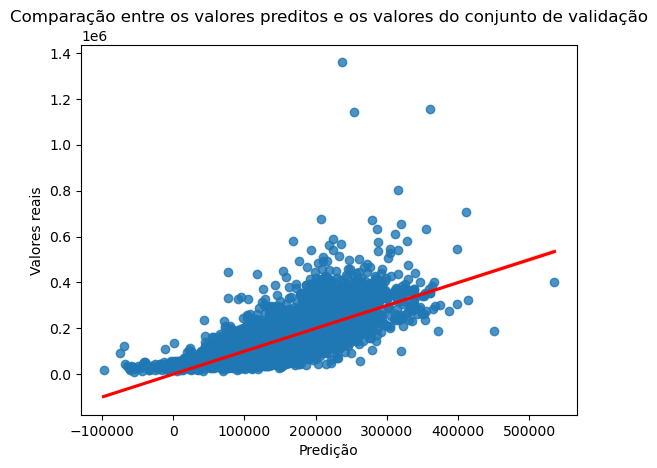

In [176]:
sns.regplot(x=y_pred3, y=y_val, line_kws={'color': 'red'})
plt.xlabel('Predição')
plt.ylabel('Valores reais')
plt.title('Comparação entre os valores preditos e os valores do conjunto de validação')
plt.show()

## Modelo 4 - RandomForest com novas features

Aplicaremos também o teste com as novas features para o modelo de florestas aleatórias. Espera-se que os resultados não variem muito dos resultados obtidos pelo Modelo 2, uma vez que já estávamos utilizando a coluna de versão dos veículos.

In [177]:
df4 = df_ft_eng.copy()
df4['tipo'] = df4['tipo'].astype('category').cat.codes
df4['cambio'] = df4['cambio'].astype('category').cat.codes
df4['cor'] = df4['cor'].astype('category').cat.codes
df4['anunciante'] = df4['anunciante'].astype('category').cat.codes
df4['combustivel'] = df4['combustivel'].astype('category').cat.codes
df4['marca'] = df4['marca'].astype('category').cat.codes
df4['modelo'] = df4['modelo'].astype('category').cat.codes
df4['versao'] = df4['versao'].astype('category').cat.codes
df4['estado_vendedor'] = df4['estado_vendedor'].astype('category').cat.codes
df4.drop(columns='cidade_vendedor', inplace=True)

X = df4.drop(columns=['preco', 'id'])
y = df4.preco

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=31)

kfold = KFold(n_splits=5, random_state=31, shuffle=True)

modelo4 = RandomForestRegressor(n_estimators=100, random_state=31, n_jobs=-1)

cv_results = cross_validate(modelo4, X_train, y_train, cv=kfold, scoring=['r2', 'neg_root_mean_squared_error'])

r2_scores_cv = cv_results['test_r2']
rmse_scores_cv = cv_results['test_neg_root_mean_squared_error']

print('Cross-validation')
print('Scores do CV (R2):', r2_scores_cv)
print('Média (R2):', r2_scores_cv.mean().round(3))
print('Scores do CV (RMSE):', rmse_scores_cv)
print('Média (RMSE):', rmse_scores_cv.mean().round(2))

print('-'*64)

print('Testes no conjunto de validação')
modelo4.fit(X_train, y_train)
y_pred4 = modelo4.predict(X_val)
r2_scores_val = r2_score(y_val, y_pred4)
rmse_scores_val = -mean_squared_error(y_val, y_pred4, squared=False)
print(f'Score R2: {r2_scores_val:.3f}')
print(f'Score RMSE: {rmse_scores_val:.2f}')

Cross-validation
Scores do CV (R2): [0.72560512 0.73287973 0.74579278 0.70048952 0.67831817]
Média (R2): 0.717
Scores do CV (RMSE): [-41676.06907268 -42492.45934084 -40015.70499839 -45852.28391507
 -46905.33825826]
Média (RMSE): -43388.37
----------------------------------------------------------------
Testes no conjunto de validação
Score R2: 0.728
Score RMSE: -42705.76


In [178]:
modelos = pd.concat([modelos,
                     pd.DataFrame([{'modelo': 'modelo4',
                                    'algoritmo': 'RandomForestRegressor',
                                    'r2_score': r2_scores_val.round(3),
                                    'rmse_score': rmse_scores_val.round(2)}]).set_index('modelo')
                                    ])
modelos.style.apply(highlight_max)

,algoritmo,r2_score,rmse_score
modelo,,,
modelo1,LinearRegression,0.426000,-62081.360000
modelo2,RandomForestRegressor,0.727000,-42773.770000
modelo3,LinearRegression,0.561000,-54261.330000
modelo4,RandomForestRegressor,0.728000,-42705.760000


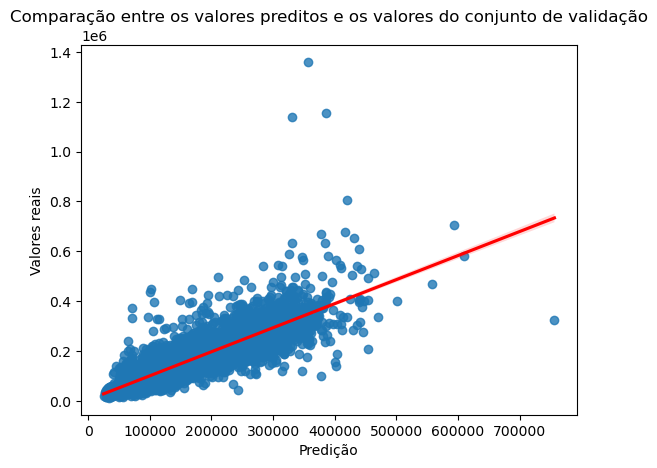

In [179]:
sns.regplot(x=y_pred4, y=y_val, line_kws={'color': 'red'})
plt.xlabel('Predição')
plt.ylabel('Valores reais')
plt.title('Comparação entre os valores preditos e os valores do conjunto de validação')
plt.show()

## Modelo 5 - SVR

In [207]:
# Criando dummies e removendo a primeira para evitar problemas de colinearidade
df5 = pd.get_dummies(df_ft_eng, columns=['tipo', 'cambio', 'cor', 'anunciante', 'combustivel'], drop_first=True)

X = df5.select_dtypes(np.number).drop(columns=['preco'])
y = df5.preco

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=31)

kfold = KFold(n_splits=5, random_state=31, shuffle=True)

modelo5 = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearSVR())
])

cv_results = cross_validate(modelo5, X_train, y_train, cv=kfold, scoring=['r2', 'neg_root_mean_squared_error'])

r2_scores_cv = cv_results['test_r2']
rmse_scores_cv = cv_results['test_neg_root_mean_squared_error']

print('Cross-validation')
print('Scores do CV (R2):', r2_scores_cv)
print('Média (R2):', r2_scores_cv.mean().round(3))
print('Scores do CV (RMSE):', rmse_scores_cv)
print('Média (RMSE):', rmse_scores_cv.mean().round(2))

print('-'*64)

print('Testes no conjunto de validação')
modelo5.fit(X_train, y_train)
y_pred5 = modelo5.predict(X_val)
r2_scores_val = r2_score(y_val, y_pred5)
rmse_scores_val = -mean_squared_error(y_val, y_pred5, squared=False)
print(f'Score R2: {r2_scores_val:.3f}')
print(f'Score RMSE: {rmse_scores_val:.2f}')

Cross-validation
Scores do CV (R2): [-2.15505467 -2.06344952 -2.14462898 -1.88585397 -1.9792524 ]
Média (R2): -2.046
Scores do CV (RMSE): [-141319.53199556 -143900.99954922 -140741.19698426 -142328.58770128
 -142745.57634284]
Média (RMSE): -142207.18
----------------------------------------------------------------
Testes no conjunto de validação
Score R2: -1.872
Score RMSE: -138832.62


In [ ]:
modelos = pd.concat([modelos,
                     pd.DataFrame([{'modelo':'modelo5',
                                    'algoritmo': 'SVR',
                                    'r2_score': r2_scores_val.round(3),
                                    'rmse_score': rmse_scores_val.round(2)}]).set_index('modelo')
                                    ])
modelos.style.apply(highlight_max)

In [ ]:
sns.regplot(x=y_pred5, y=y_val, line_kws={'color': 'red'})
plt.xlabel('Predição')
plt.ylabel('Valores reais')
plt.title('Comparação entre os valores preditos e os valores do conjunto de validação')
plt.show()

## Modelo 5 - ElasticNet

A seguir, testaremos o modelo de ElasticNet. O algoritmo utiliza alguns parâmetros de penalização

In [180]:
# Criando dummies e removendo a primeira para evitar problemas de colinearidade
df5 = pd.get_dummies(df_ft_eng, columns=['tipo', 'cambio', 'cor', 'anunciante', 'combustivel'], drop_first=True)

X = df5.select_dtypes(np.number).drop(columns=['preco'])
y = df5.preco

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=31)

kfold = KFold(n_splits=5, random_state=31, shuffle=True)

modelo5 = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', ElasticNet())
])

cv_results = cross_validate(modelo5, X_train, y_train, cv=kfold, scoring=['r2', 'neg_root_mean_squared_error'])

r2_scores_cv = cv_results['test_r2']
rmse_scores_cv = cv_results['test_neg_root_mean_squared_error']

print('Cross-validation')
print('Scores do CV (R2):', r2_scores_cv)
print('Média (R2):', r2_scores_cv.mean().round(3))
print('Scores do CV (RMSE):', rmse_scores_cv)
print('Média (RMSE):', rmse_scores_cv.mean().round(2))

print('-'*64)

print('Testes no conjunto de validação')
modelo5.fit(X_train, y_train)
y_pred5 = modelo5.predict(X_val)
r2_scores_val = r2_score(y_val, y_pred5)
rmse_scores_val = -mean_squared_error(y_val, y_pred5, squared=False)
print(f'Score R2: {r2_scores_val:.3f}')
print(f'Score RMSE: {rmse_scores_val:.2f}')

Cross-validation
Scores do CV (R2): [0.58522166 0.5602566  0.57624086 0.52670351 0.53604154]
Média (R2): 0.557
Scores do CV (RMSE): [-51239.72368969 -54520.28450652 -51664.95730523 -57639.68631033
 -56331.1422741 ]
Média (RMSE): -54279.16
----------------------------------------------------------------
Testes no conjunto de validação
Score R2: 0.561
Score RMSE: -54255.80


In [181]:
modelos = pd.concat([modelos,
                     pd.DataFrame([{'modelo':'modelo5',
                                    'algoritmo': 'Ridge',
                                    'r2_score': r2_scores_val.round(3),
                                    'rmse_score': rmse_scores_val.round(2)}]).set_index('modelo')
                                    ])
modelos.style.apply(highlight_max)

,algoritmo,r2_score,rmse_score
modelo,,,
modelo1,LinearRegression,0.426000,-62081.360000
modelo2,RandomForestRegressor,0.727000,-42773.770000
modelo3,LinearRegression,0.561000,-54261.330000
modelo4,RandomForestRegressor,0.728000,-42705.760000
modelo5,Ridge,0.561000,-54255.800000


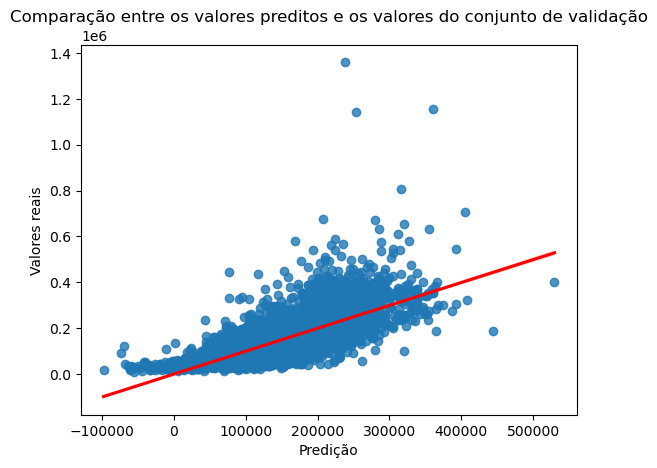

In [182]:
sns.regplot(x=y_pred5, y=y_val, line_kws={'color': 'red'})
plt.xlabel('Predição')
plt.ylabel('Valores reais')
plt.title('Comparação entre os valores preditos e os valores do conjunto de validação')
plt.show()

## Modelo 6 - Lasso

In [183]:
# Criando dummies e removendo a primeira para evitar problemas de colinearidade
df6 = pd.get_dummies(df_ft_eng, columns=['tipo', 'cambio', 'cor', 'anunciante', 'combustivel'], drop_first=True)

X = df6.select_dtypes(np.number).drop(columns=['preco'])
y = df6.preco

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=31)

kfold = KFold(n_splits=5, random_state=31, shuffle=True)

modelo6 = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Lasso())
])

cv_results = cross_validate(modelo6, X_train, y_train, cv=kfold, scoring=['r2', 'neg_root_mean_squared_error'])

r2_scores_cv = cv_results['test_r2']
rmse_scores_cv = cv_results['test_neg_root_mean_squared_error']

print('Cross-validation')
print('Scores do CV (R2):', r2_scores_cv)
print('Média (R2):', r2_scores_cv.mean().round(3))
print('Scores do CV (RMSE):', rmse_scores_cv)
print('Média (RMSE):', rmse_scores_cv.mean().round(2))

print('-'*64)

print('Testes no conjunto de validação')
modelo6.fit(X_train, y_train)
y_pred6 = modelo6.predict(X_val)
r2_scores_val = r2_score(y_val, y_pred6)
rmse_scores_val = -mean_squared_error(y_val, y_pred6, squared=False)
print(f'Score R2: {r2_scores_val:.3f}')
print(f'Score RMSE: {rmse_scores_val:.2f}')

c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.094e+13, tolerance: 1.115e+10
  model = cd_fast.enet_coordinate_descent(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.052e+13, tolerance: 1.097e+10
  model = cd_fast.enet_coordinate_descent(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e+13, toleranc

Cross-validation
Scores do CV (R2): [0.58527305 0.56033039 0.57618464 0.52700872 0.53585343]
Média (R2): 0.557
Scores do CV (RMSE): [-51236.54951628 -54515.70989574 -51668.38434716 -57621.09842579
 -56342.5610293 ]
Média (RMSE): -54276.86
----------------------------------------------------------------
Testes no conjunto de validação
Score R2: 0.561
Score RMSE: -54251.37


c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.514e+13, tolerance: 1.377e+10
  model = cd_fast.enet_coordinate_descent(


In [184]:
modelos = pd.concat([modelos,
                     pd.DataFrame([{'modelo':'modelo6',
                                    'algoritmo': 'Lasso',
                                    'r2_score': r2_scores_val.round(3),
                                    'rmse_score': rmse_scores_val.round(2)}]).set_index('modelo')
                                    ])
modelos.style.apply(highlight_max)

,algoritmo,r2_score,rmse_score
modelo,,,
modelo1,LinearRegression,0.426000,-62081.360000
modelo2,RandomForestRegressor,0.727000,-42773.770000
modelo3,LinearRegression,0.561000,-54261.330000
modelo4,RandomForestRegressor,0.728000,-42705.760000
modelo5,Ridge,0.561000,-54255.800000
modelo6,Lasso,0.561000,-54251.370000


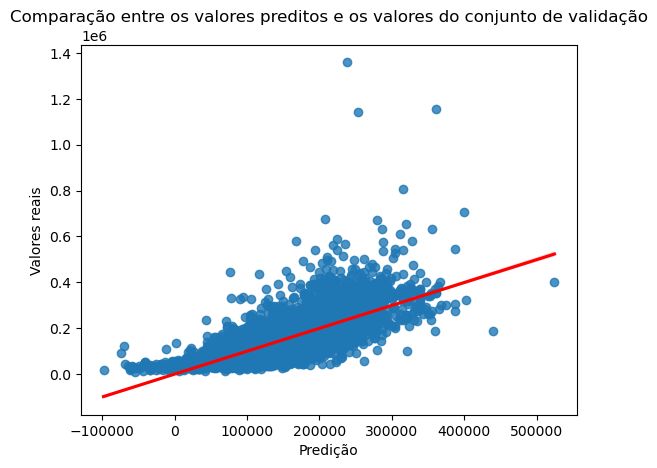

In [185]:
sns.regplot(x=y_pred6, y=y_val, line_kws={'color': 'red'})
plt.xlabel('Predição')
plt.ylabel('Valores reais')
plt.title('Comparação entre os valores preditos e os valores do conjunto de validação')
plt.show()

## Modelo 7 - ElasticNet

In [186]:
# Criando dummies e removendo a primeira para evitar problemas de colinearidade
df7 = pd.get_dummies(df_ft_eng, columns=['tipo', 'cambio', 'cor', 'anunciante', 'combustivel'], drop_first=True)

X = df7.select_dtypes(np.number).drop(columns=['preco'])
y = df7.preco

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=31)

kfold = KFold(n_splits=5, random_state=31, shuffle=True)

modelo7 = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Lasso())
])

cv_results = cross_validate(modelo7, X_train, y_train, cv=kfold, scoring=['r2', 'neg_root_mean_squared_error'])

r2_scores_cv = cv_results['test_r2']
rmse_scores_cv = cv_results['test_neg_root_mean_squared_error']

print('Cross-validation')
print('Scores do CV (R2):', r2_scores_cv)
print('Média (R2):', r2_scores_cv.mean().round(3))
print('Scores do CV (RMSE):', rmse_scores_cv)
print('Média (RMSE):', rmse_scores_cv.mean().round(2))

print('-'*64)

print('Testes no conjunto de validação')
modelo7.fit(X_train, y_train)
y_pred7 = modelo7.predict(X_val)
r2_scores_val = r2_score(y_val, y_pred6)
rmse_scores_val = -mean_squared_error(y_val, y_pred6, squared=False)
print(f'Score R2: {r2_scores_val:.3f}')
print(f'Score RMSE: {rmse_scores_val:.2f}')

c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.094e+13, tolerance: 1.115e+10
  model = cd_fast.enet_coordinate_descent(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.052e+13, tolerance: 1.097e+10
  model = cd_fast.enet_coordinate_descent(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e+13, toleranc

Cross-validation
Scores do CV (R2): [0.58527305 0.56033039 0.57618464 0.52700872 0.53585343]
Média (R2): 0.557
Scores do CV (RMSE): [-51236.54951628 -54515.70989574 -51668.38434716 -57621.09842579
 -56342.5610293 ]
Média (RMSE): -54276.86
----------------------------------------------------------------
Testes no conjunto de validação
Score R2: 0.561
Score RMSE: -54251.37


c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.514e+13, tolerance: 1.377e+10
  model = cd_fast.enet_coordinate_descent(


In [187]:
modelos = pd.concat([modelos,
                     pd.DataFrame([{'modelo':'modelo7',
                                    'algoritmo': 'ElasticNet',
                                    'r2_score': r2_scores_val.round(3),
                                    'rmse_score': rmse_scores_val.round(2)}]).set_index('modelo')
                                    ])
modelos.style.apply(highlight_max)

,algoritmo,r2_score,rmse_score
modelo,,,
modelo1,LinearRegression,0.426000,-62081.360000
modelo2,RandomForestRegressor,0.727000,-42773.770000
modelo3,LinearRegression,0.561000,-54261.330000
modelo4,RandomForestRegressor,0.728000,-42705.760000
modelo5,Ridge,0.561000,-54255.800000
modelo6,Lasso,0.561000,-54251.370000
modelo7,ElasticNet,0.561000,-54251.370000


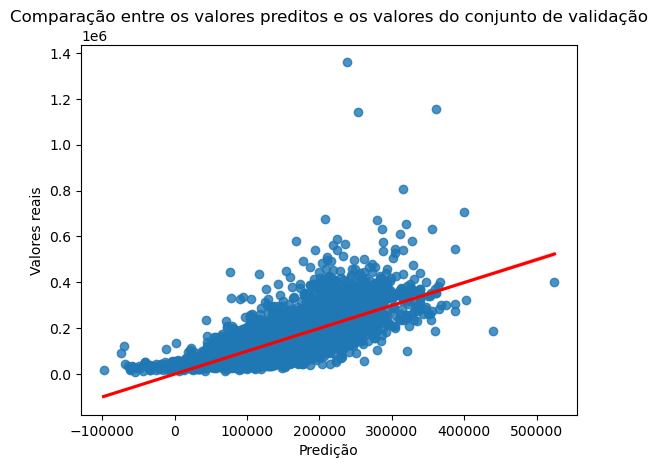

In [188]:
sns.regplot(x=y_pred7, y=y_val, line_kws={'color': 'red'})
plt.xlabel('Predição')
plt.ylabel('Valores reais')
plt.title('Comparação entre os valores preditos e os valores do conjunto de validação')
plt.show()